### Assess Novelty in the Control Dataset

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from MINOV.novelty import compute_MI_novelty
from utils import *

from pymatgen.core import Structure
from tqdm import tqdm, trange

import textalloc as ta
import matplotlib.pyplot as plt
import matplotlib as mpl
from style import mpl_style
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load formulas and structures from dataset folder.

In [141]:
MAT_DS = "diverse_dataset"
DS_PATH = os.path.join("data", MAT_DS)
# get all cif files in folder
files = [file for file in os.listdir(DS_PATH) if ".cif" in file]

structures = []
formulas = []
space_group_numbers = []
unit_cell_vols = []
for filename in files:
    structure = Structure.from_file(os.path.join(DS_PATH, filename))
    structures.append(structure)
    formulas.append(str(structure.formula))
    try:
        space_group_numbers.append(structure.get_space_group_info()[1]) 
    except:
        space_group_numbers.append(194)
    unit_cell_vols.append(structure.volume)


data = pd.DataFrame({"formula": formulas, "structure": structures, "spacegroup": space_group_numbers, "volume": unit_cell_vols, "filename": files})

### Compute material densities using MI decay profile.

Optionally, you can regenerate distance matrices from the data.

In [142]:
data, mi_data = compute_MI_novelty(
    data = data,
    compute_metrics = None,
    precomputed_metrics={
        "lostop": "diverse_dataset_lostop_dm.npy",
        "elmd": "diverse_dataset_elmd_dm.npy",
        },
    data_dir="precomputed",
    data_prefix=MAT_DS,
)

MI cutoff for lostop: 2.609167221406347
MI cutoff for elmd: 14.54604910552764


### Plot MI Profiles for LoStOP and ElMD

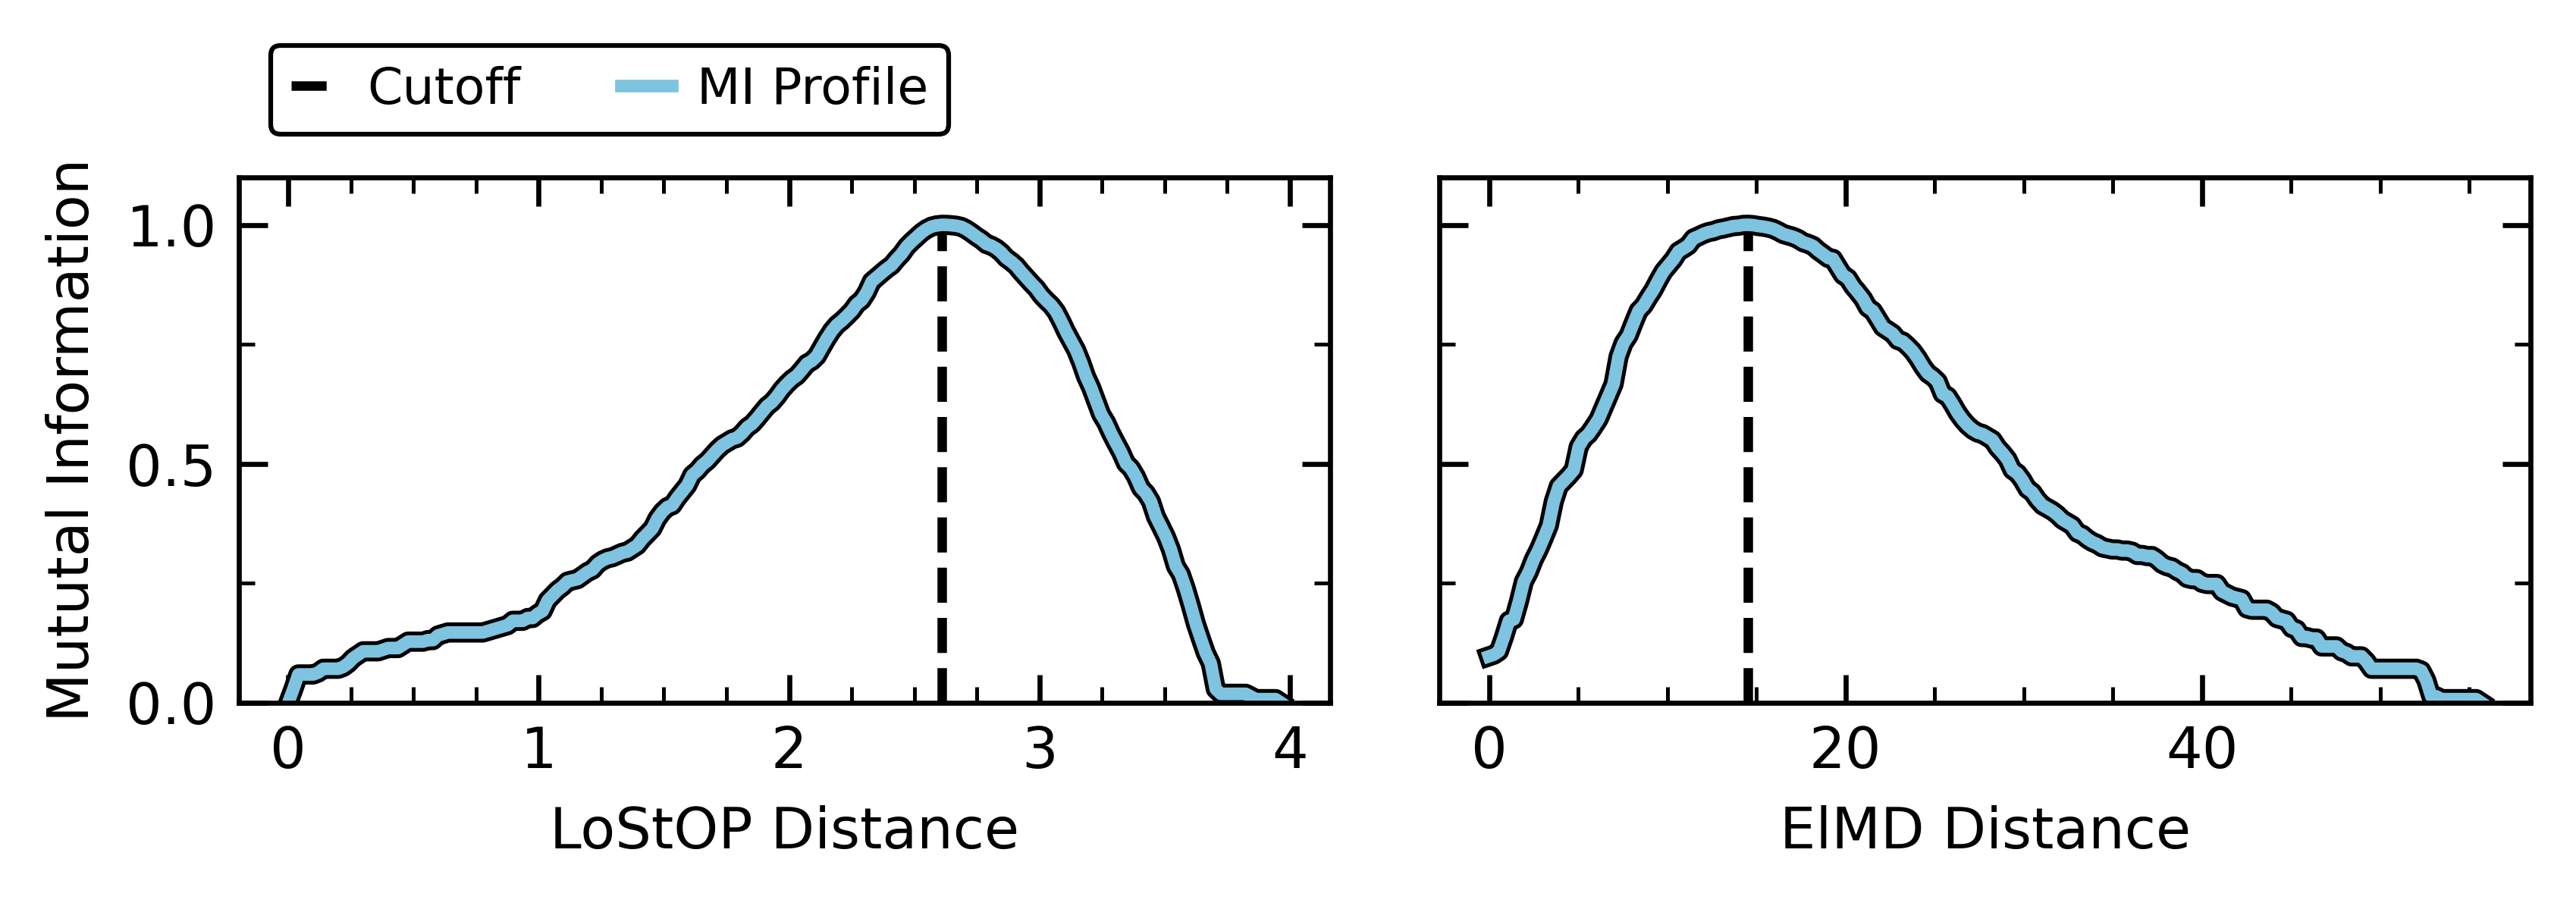

In [143]:
fig, ax = plt.subplots(ncols=2, figsize=(6.5, 1.5), sharey=True, dpi=600)
plt.subplots_adjust(wspace=0.1)

ax[0].vlines(x=mi_data['lostop']['cutoff'], ymin=0, ymax=1.0, color='black', lw=1.5, ls='--', label='Cutoff')
ax[0].plot(mi_data['lostop']['tau'], mi_data['lostop']['mi_profile'], color='black', lw=3.2,)
ax[0].plot(mi_data['lostop']['tau'], mi_data['lostop']['mi_profile'], color='#7EC3E0', lw=2, label='MI Profile')
ax[0].set_yticks([0, 0.5, 1.0])
ax[0].set_ylim(0, 1.1)
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax[0].set_ylabel("Mututal Information")
ax[0].set_xlabel("LoStOP Distance")

ax[1].vlines(x=mi_data['elmd']['cutoff'], ymin=0, ymax=1, color='black', lw=1.5, ls='--', label='Cutoff')
ax[1].plot(mi_data['elmd']['tau'], mi_data['elmd']['mi_profile'], color='black', lw=3.2,)
ax[1].plot(mi_data['elmd']['tau'], mi_data['elmd']['mi_profile'], color='#7EC3E0', lw=2, label='MI Profile')
ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax[1].set_xlabel("ElMD Distance")

legend = ax[0].legend(loc='lower center', fontsize=8, frameon=True, framealpha=1.0, labelspacing=0.25, bbox_to_anchor=(0.34, 1.0), ncol=2)
legend.get_frame().set_linewidth(0.75)

plt.show()

### Plot material densities along ElMD and LoStOP axes

Custom matplotlib styles have been applied.


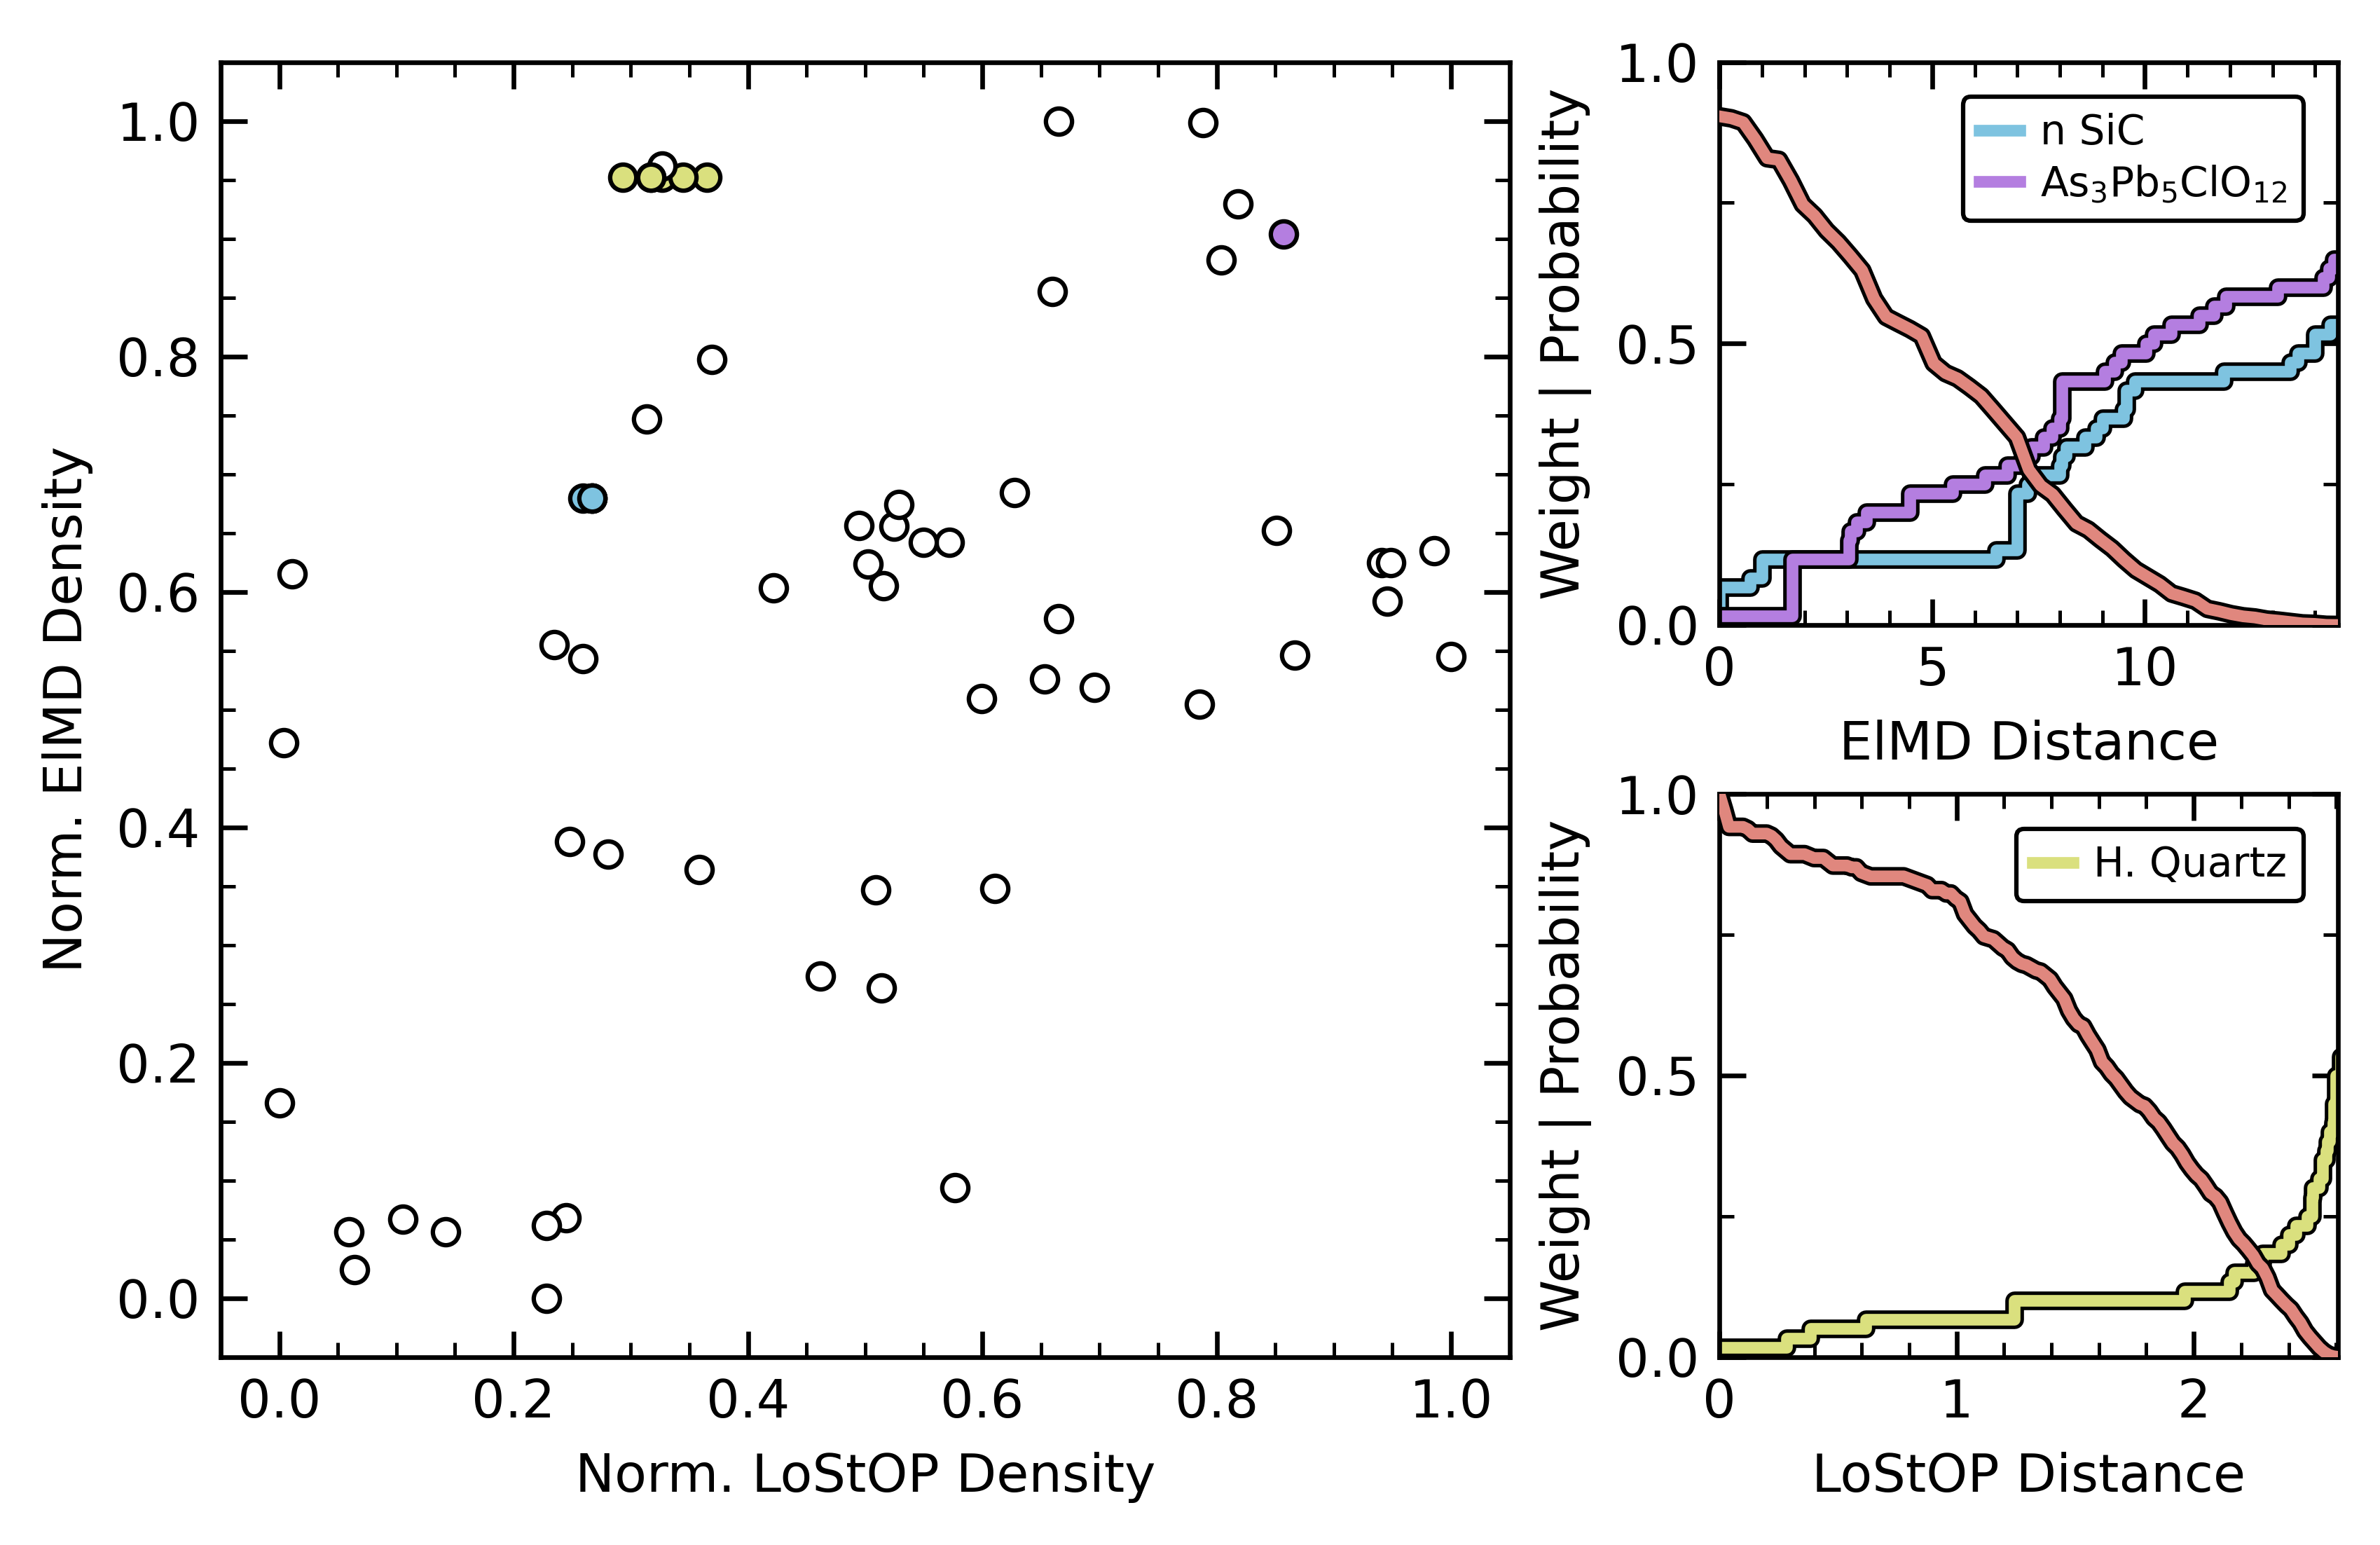

In [144]:
scaled_df = data.copy()

# scale the scaled_df
scaled_df[['lostop_density', 'elmd_density']] = MinMaxScaler().fit_transform(scaled_df[['lostop_density', 'elmd_density']])

fig = plt.figure(figsize=(6.5, 4), dpi=600)
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=(1, 0.48), hspace=0.3, wspace=0.22)

main_scatter = fig.add_subplot(gs[:, 0])

for i, row in enumerate(range(len(scaled_df))):
    main_scatter.scatter(
        scaled_df['lostop_density'].loc[i],
        scaled_df['elmd_density'].loc[i], 
        s=20, 
        zorder=9, 
        lw=0.75, 
        ec='k', 
        fc="#7EC3E0" if i in [0, 31, 34, 37] else "#B47EE0" if i in [7] else "#DAE07E" if i in [20, 21, 24, 26, 46, 50] else "white")

main_scatter.set_xlabel("Norm. LoStOP Density")
main_scatter.set_ylabel("Norm. ElMD Density")

sic_plot = fig.add_subplot(gs[0, 1])
sic_plot.plot(mi_data['elmd']['tau'], mi_data['elmd']['weight_function'], color='k', lw=3.2, zorder=4)
sic_plot.plot(mi_data['elmd']['tau'], mi_data['elmd']['weight_function'], color='#E0877E', lw=2, zorder=5)#, label='Decay Weight')

elmd_dm = np.load("precomputed/diverse_dataset_elmd_dm.npy")
for i, row in enumerate(elmd_dm):
    count = np.ones(row.shape[0])
    cs = np.cumsum(count)/np.sum(count)
    if i in [0]: # SiC index
        sic_plot.step(np.sort(row), cs, color='k', alpha=1, lw=3.2, where='post')
        sic_plot.step(np.sort(row), cs, color='#7EC3E0', alpha=1, lw=2, where='post', label='n SiC')
    elif i in [7]: # As3Pb5ClO12 index
        sic_plot.step(np.sort(row), cs, color='k', alpha=1, lw=3.2, where='post')
        sic_plot.step(np.sort(row), cs, color='#B47EE0', alpha=1, lw=2, where='post', label='As$_3$Pb$_5$ClO$_{12}$')
    else:
        continue

sic_plot.set_xlim(0, mi_data['elmd']['cutoff'])
sic_plot.set_ylim(0, 1.0)
sic_plot.set_yticks([0, 0.5, 1.0])
sic_plot.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))

sic_plot.set_xlabel("ElMD Distance")
sic_plot.set_ylabel("Weight | Probability")

sic_legend = sic_plot.legend(loc='upper right', fontsize=7, frameon=True, framealpha=1.0, labelspacing=0.25)
sic_legend.get_frame().set_linewidth(0.75)

sio_plot = fig.add_subplot(gs[1, 1])
sio_plot.plot(mi_data['lostop']['tau'], mi_data['lostop']['weight_function'], color='k', lw=3.2, zorder=3)
sio_plot.plot(mi_data['lostop']['tau'], mi_data['lostop']['weight_function'], color='#E0877E', lw=2, zorder=4)#, label='Decay Weight')

lostop_dm = np.load("precomputed/diverse_dataset_lostop_dm.npy")
for i, row in enumerate(lostop_dm):
    count = np.ones(row.shape[0])
    cs = np.cumsum(count)/np.sum(count)
    if i in [21]: # high quartz SiO2 index
        sio_plot.step(np.sort(row), cs, color='k', alpha=1, lw=3.2, where='post', zorder=1)
        sio_plot.step(np.sort(row), cs, color='#DAE07E', alpha=1, lw=2,  where='post', zorder=2, label='H. Quartz')
    else:
        continue

sio_plot.set_xlim(0, mi_data['lostop']['cutoff'])
sio_plot.set_ylim(0, 1.0)
sio_plot.set_yticks([0, 0.5, 1.0])
sio_plot.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))

sio_plot.set_xlabel("LoStOP Distance")
sio_plot.set_ylabel("Weight | Probability")

sio_legend = sio_plot.legend(loc='upper right', fontsize=7, frameon=True, framealpha=1.0, labelspacing=0.25)
sio_legend.get_frame().set_linewidth(0.75)

plt.show()

Note that the publication figure was adjusted post-hoc for visual clarity due to positioning issues with the `textalloc` library.

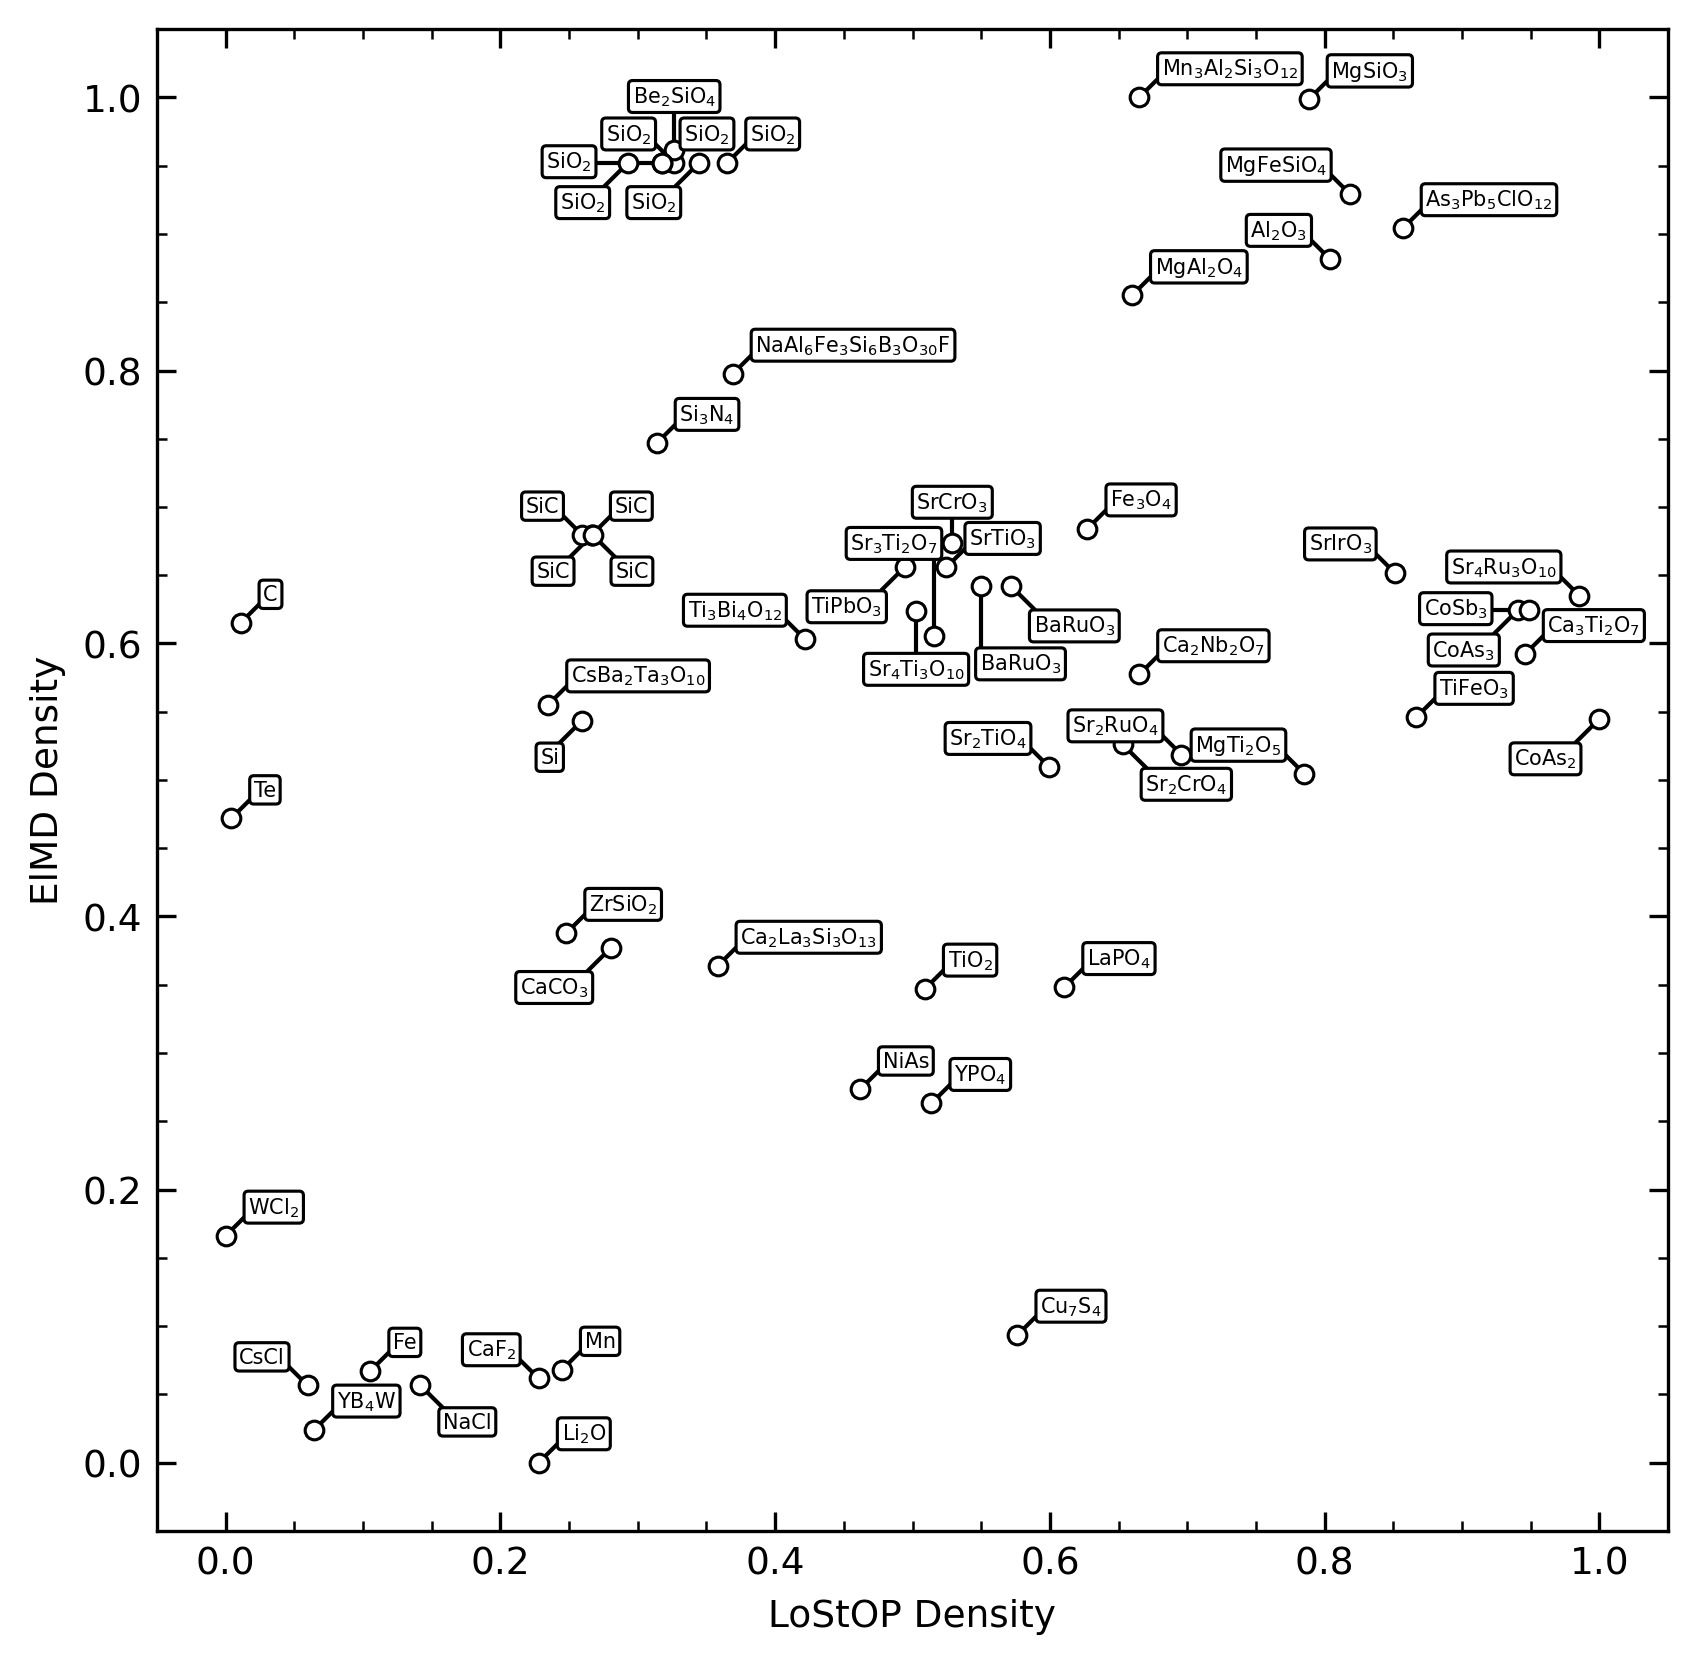

In [147]:
fig, ax = plt.subplots(figsize=(6.5, 6.5), dpi=300)

ax.scatter(
    scaled_df['lostop_density'],
    scaled_df['elmd_density'],
    s=20, 
    zorder=9, 
    lw=0.75, 
    ec='k',
    fc='w',
)

labels = [reduce_single_formula(formula) for formula in scaled_df['formula'].values]

ta.allocate(ax,
            x=scaled_df['lostop_density'],
            y=scaled_df['elmd_density'],
            text_list=labels,
            x_scatter=scaled_df['lostop_density'].values,
            y_scatter=scaled_df['elmd_density'].values,
            textsize=5,
            min_distance=0.015,
            max_distance=0.07,
            nbr_candidates=1000,
            linecolor='k',
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="k", pad=0.2, lw=0.75),
            zorder=15,
            )

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)


# Set labels
ax.set_xlabel("LoStOP Density")
ax.set_ylabel("ElMD Density")
plt.show()

### Analysis of CN4 and CN5 Environments in Dataset

Below we plot average affinity for 4-fold and 5-fold coordination environments across the dataset.

100%|██████████| 60/60 [00:56<00:00,  1.06it/s]


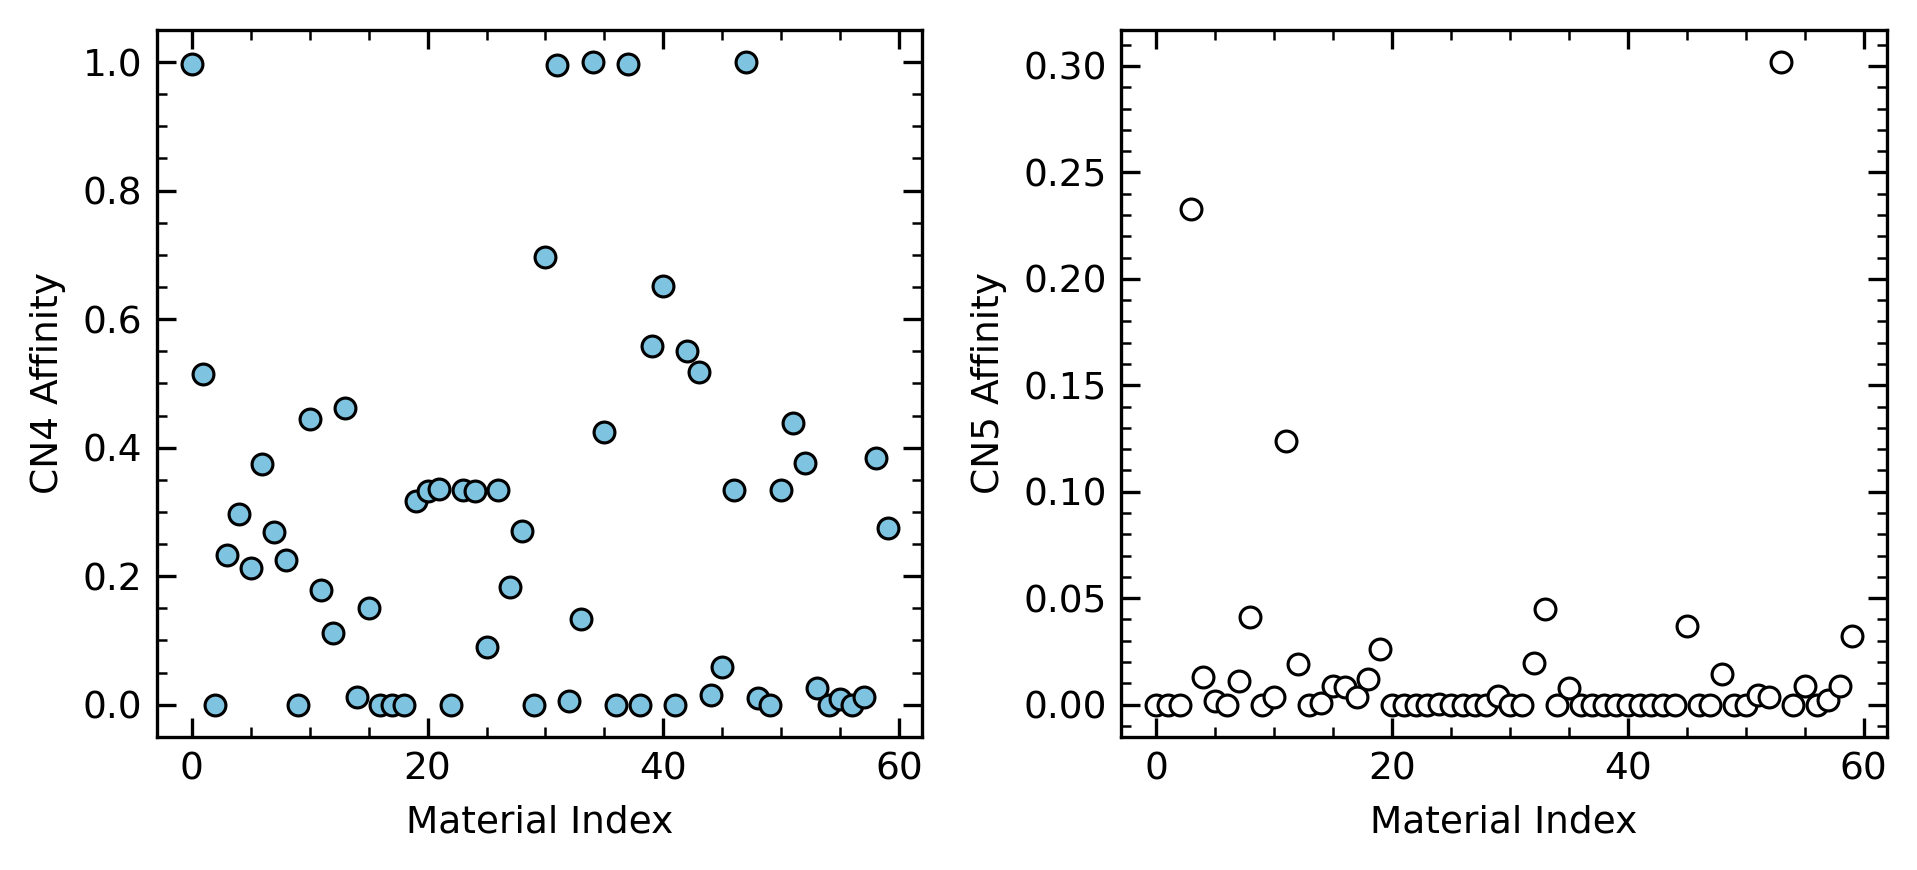

In [132]:
from matminer.featurizers.site.fingerprint import CrystalNNFingerprint
cnnf = CrystalNNFingerprint.from_preset("ops")

CN4s = []
CN5s = []
for struct in trange(len(data)):

    structure = data.loc[struct, "structure"]
    n_sites = len(structure)
    site_CN4s = []
    site_CN5s = []
    for site in range(n_sites):
        feat = cnnf.featurize(structure, site)
        site_CN4s.append(feat[12])
        site_CN5s.append(feat[20])
        
    CN4s.append(np.mean(site_CN4s))
    CN5s.append(np.mean(site_CN5s))

data["CN4"] = CN4s
data["CN5"] = CN5s

fig, ax = plt.subplots(ncols=2, figsize=(6.5, 3), dpi=300, layout='tight')

ax[0].plot(data['CN4'], marker='.', color='#7EC3E0', ls='None', ms=10, mec='k')
ax[0].set_ylabel("CN4 Affinity")
ax[0].set_xlabel("Material Index")

ax[1].plot(data['CN5'], marker='.', color='w', ls='None', ms=10, mec='k')
ax[1].set_ylabel("CN5 Affinity")
ax[1].set_xlabel("Material Index")
plt.show()

### Analysis of Novelty
Here we assess the coordination environments that make each compound unique relative to its neighbors.

In [133]:
from MINOV.distance import process_structure

idx = 55 # WCl2
print(f"Reference compound formula: {data.loc[idx, 'formula']}")
reference_fp, reference_feats = process_structure(0, data.loc[idx, "structure"])

# Find 30 (arbitrary) nearest neighbors
nearest = np.argsort(lostop_dm[idx])[1:30]

# Initialize lists to store differences
feature_diffs = []
neighbor_info = []
neighbor_fps = []

# Compare each neighbor with the reference
for neighbor in tqdm(nearest):
    # Get neighbor fingerprint
    neighbor_fp, neighbor_feats = process_structure(0, data.loc[neighbor, "structure"])
    neighbor_info.append((neighbor, data.loc[neighbor, "formula"]))
    neighbor_fps.append(neighbor_fp)
    
    # Calculate absolute differences for each feature
    diffs = np.array(reference_fp) - np.array(neighbor_fp)
    feature_diffs.append(diffs)

# Convert to numpy array for easier manipulation
feature_diffs = np.array(feature_diffs)

# Calculate average difference for each feature across all neighbors
avg_diffs = np.mean(feature_diffs, axis=0)

# Get indices of features sorted by average difference (largest first)
sorted_feature_indices = np.argsort(avg_diffs)[::-1]

# Print the features with the largest differences
print("\nFeatures with largest differences between reference and neighbors:")

for i, feat_idx in enumerate(sorted_feature_indices[:3]):
    print(f"\n{i+1}. Feature {reference_feats[feat_idx]}: Average difference = {avg_diffs[feat_idx]:.4f}")
    print(f"   Reference value: {reference_fp[feat_idx]}")
    print("   Neighbor values:")
    for j, (neighbor, formula) in enumerate(neighbor_info[:5]):
        print(f"      {formula} (ID: {neighbor}): {neighbor_fps[j][feat_idx]:.4f} (Diff: {feature_diffs[j][feat_idx]:.4f})")

Reference compound formula: Sr4 Ru2 O8


100%|██████████| 29/29 [00:30<00:00,  1.04s/it]


Features with largest differences between reference and neighbors:

1. Feature maximum_wt CN_9: Average difference = 0.5768
   Reference value: 0.72006405197781
   Neighbor values:
      Sr4 Ti2 O8 (ID: 17): 0.7918 (Diff: -0.0718)
      Sr4 Cr2 O8 (ID: 32): 0.7640 (Diff: -0.0439)
      Sr16 Ru12 O40 (ID: 12): 0.5571 (Diff: 0.1630)
      Co8 Sb24 (ID: 28): 0.0000 (Diff: 0.7201)
      Sr12 Ir12 O36 (ID: 45): 0.0166 (Diff: 0.7035)

2. Feature std_dev_wt CN_9: Average difference = 0.2703
   Reference value: 0.3252917807799645
   Neighbor values:
      Sr4 Ti2 O8 (ID: 17): 0.3577 (Diff: -0.0324)
      Sr4 Cr2 O8 (ID: 32): 0.3451 (Diff: -0.0198)
      Sr16 Ru12 O40 (ID: 12): 0.1784 (Diff: 0.1469)
      Co8 Sb24 (ID: 28): 0.0000 (Diff: 0.3253)
      Sr12 Ir12 O36 (ID: 45): 0.0056 (Diff: 0.3197)

3. Feature maximum_q6 CN_9: Average difference = 0.2662
   Reference value: 0.3326844320121774
   Neighbor values:
      Sr4 Ti2 O8 (ID: 17): 0.3797 (Diff: -0.0471)
      Sr4 Cr2 O8 (ID: 32): 0.3607 